# Testing Misc Methods

## Dataloader with augmentation test

## Learning rate finder

/home/shrek/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Constructing DeepLabv3+ model...
Number of classes: 2
Output stride: 8
Number of Input Channels: 3
Let's use 2 GPUs!


/home/shrek/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/shrek/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


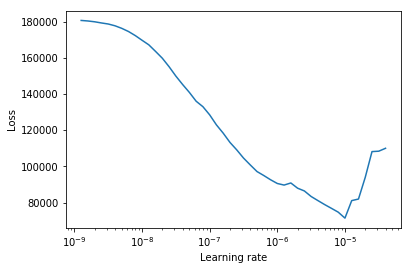

In [1]:
import socket
import timeit
from datetime import datetime
import os
import glob
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import argparse
from imgaug import augmenters as iaa
import imgaug as ia


# PyTorch includes
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn


# Tensorboard include
from tensorboardX import SummaryWriter

# Custom includes
from dataloaders.alphapilot import AlphaPilotSegmentation
from dataloaders import utils
from networks import deeplab_xception, deeplab_resnet
# from dataloaders import custom_transforms as tr
from networks import unet
from lr_finder import LRFinder

p = OrderedDict()  # Parameters to include in report
p['trainBatchSize'] = 4  # Training batch size
testBatchSize = 1 # Testing batch size
useTest = True  # See evolution of the test set when training
nTestInterval = 1  # Run on test set every nTestInterval epochs
snapshot = 2  # Store a model every snapshot epochs

p['nAveGrad'] = 1  # Average the gradient of several iterations
p['lr'] = 1e-10  # Learning rate
p['wd'] = 5e-4  # Weight decay
p['momentum'] = 0.9  # Momentum
p['epoch_size'] = 2  # How many epochs to change learning rate

p['Model'] = 'deeplab'  # Choose model: unet or deeplab
backbone = 'xception'  # For deeplab only: Use xception or resnet as feature extractor,
num_of_classes = 2
imsize = 512  # 256 or 512
output_stride = 8 # 8 or 16, 8 is better. Controls output stride of the deeplab model, which increases resolution of convolutions.
numInputChannels = 3

# Network definition
if p['Model'] == 'deeplab':
    if backbone == 'xception':
        net = deeplab_xception.DeepLabv3_plus(nInputChannels=numInputChannels, n_classes=num_of_classes, os=output_stride, pretrained=True)
    elif backbone == 'resnet':
        net = deeplab_resnet.DeepLabv3_plus(nInputChannels=numInputChannels, n_classes=num_of_classes, os=output_stride, pretrained=True)
    else:
        raise NotImplementedError
    modelName = 'deeplabv3plus-' + backbone

    # Use the following optimizer
    optimizer = optim.SGD(net.parameters(), lr=p['lr'], momentum=p['momentum'], weight_decay=p['wd'])
    p['optimizer'] = str(optimizer)

    # Use the following loss function
    criterion = utils.cross_entropy2d
else:
    raise NotImplementedError
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#criterion = criterion.to(device) #TODO: IS THIS NEEDED?



# Enable Multi-GPU training
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    net = nn.DataParallel(net)

augs_train = iaa.Sequential([
    # Geometric Augs
    iaa.Scale((imsize, imsize), 0),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rot90((0, 4)),
    # Blur and Noise
    #iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 1.5), name="gaus-blur")),
    #iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0), from_colorspace="RGB", name="grayscale")),
    # iaa.Sometimes(0.2, iaa.AdditiveLaplaceNoise(scale=(0, 0.1*255), per_channel=True, name="gaus-noise")),
    # Color, Contrast, etc.
    iaa.Sometimes(0.2, iaa.Multiply((0.75, 1.25), per_channel=0.1, name="brightness")),
    iaa.Sometimes(0.2, iaa.GammaContrast((0.7, 1.3), per_channel=0.1, name="contrast")),
    iaa.Sometimes(0.2, iaa.AddToHueAndSaturation((-20, 20), name="hue-sat")),
    iaa.Sometimes(0.3, iaa.Add((-20, 20), per_channel=0.5, name="color-jitter")),
])
augs_test = iaa.Sequential([
    # Geometric Augs
    iaa.Scale((imsize, imsize), 0),
])


db_train = AlphaPilotSegmentation(
    input_dir='data/dataset/train/images', label_dir='data/dataset/train/labels',
    transform=augs_train,
    input_only=["gaus-blur", "grayscale", "gaus-noise", "brightness", "contrast", "hue-sat", "color-jitter"],
    return_image_name=False
)


trainloader = DataLoader(db_train, batch_size=p['trainBatchSize'], shuffle=True, num_workers=32, drop_last=True)


%matplotlib inline

lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot()
# plt.show()

# Inference AlphaPilot Test

Constructing DeepLabv3+ model...
Number of classes: 2
Output stride: 8
Number of Input Channels: 3


/home/shrek/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


mask shape: (512, 512) mask dtype: uint8 mask max value: 255


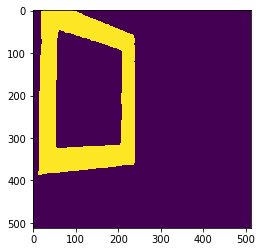

In [2]:
import cv2
from inference_alphapilot import inferenceAlphaPilot
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


inference = inferenceAlphaPilot(checkpoint_path = 'checkpoint/checkpoint.pth'
                                )
pathInputImage = 'data/dataset/test/images/IMG_0008.JPG'
img =cv2.imread(pathInputImage)
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = inference.inferenceOnNumpy(img)
print('mask shape:', mask.shape, 'mask dtype:', mask.dtype,'mask max value:', np.amax(mask))

plt.imshow(mask)

